##### based on https://github.com/ageron/handson-ml/blob/master/extra_capsnets.ipynb

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import tensorflow as tf

/home/key/software/anaconda3/envs/tf3.5/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
tf.reset_default_graph()

### load MNIST

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


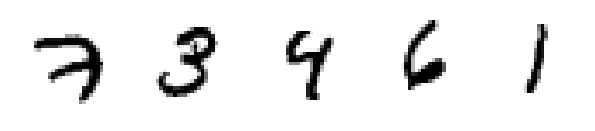

In [5]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = mnist.train.images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

In [6]:
mnist.train.labels[:n_samples]

array([7, 3, 4, 6, 1], dtype=uint8)

### Input

In [7]:
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")


### First conv layer

256 filters with a 9x9 kernel

output shape will be 20x20 because of no padding

In [8]:
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid", # = none
    "activation": tf.nn.relu,
}

conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)
conv1

<tf.Tensor 'conv1/Relu:0' shape=(?, 20, 20, 256) dtype=float32>

### Second conv layer == Primary capsules

_The second layer (PrimaryCapsules) is a convolutional capsule layer with 32 channels of convolutional 8D capsules (i.e. each primary capsule contains 8 convolutional units with a 9 × 9 kernel and a stride of 2)._

- 32 primary capsules

- Each capsule contains 8 conv units so we have 32x8 = 256 conv units overall

- There are 32x6x6 = 1152 8d outputs

_In total PrimaryCapsules has [32×6×6] capsule outputs (each output is an 8D vector) and each capsule in the
[6×6] grid is sharing their weights with each other._

In [9]:
caps1_n_maps = 32 # primary capsules
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsule outputs
caps1_n_dims = 8  # conv units per capsule

In [10]:
conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}
conv2 = tf.layers.conv2d(conv1, name="conv2", **conv2_params)
conv2

<tf.Tensor 'conv2/Relu:0' shape=(?, 6, 6, 256) dtype=float32>

In [11]:
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                       name="caps1_raw")
caps1_raw

<tf.Tensor 'caps1_raw:0' shape=(?, 1152, 8) dtype=float32>